# Logistic regression of classification problem
## Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Import data 

In [2]:
# invert one hot encoding
def combine_binary_columns(df):
    target_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
    # the column contains as an entry the name of the column, if the value is 1, if more then 1 column is 1 then the naming is Target1_Target2
    df['Target'] = df[target_columns].apply(lambda row: '_'.join(row[row == 1].index), axis=1)
    # drop the old columns
    df = df.drop(columns=target_columns)
    # replace '' with 'None'
    df['Target'] = df['Target'].replace('', 'None')
    return df

In [3]:
# load in data
df_train = combine_binary_columns(pd.read_csv('/home/tomruge/Schreibtisch/Data/Kaggle/playground-series-s4e3/train.csv'))
df_test = pd.read_csv('/home/tomruge/Schreibtisch/Data/Kaggle/playground-series-s4e3/test.csv')

# targets are Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults
X_train = df_train.drop('Target', axis=1)
y_train = df_train['Target']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Model

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# create pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, n_jobs=-1, multi_class='multinomial', solver='lbfgs'))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    n_jobs=-1))])

In [5]:
# evaluate model
from sklearn.metrics import classification_report
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))


                precision    recall  f1-score   support

         Bumps       0.46      0.47      0.47       924
     Dirtiness       0.42      0.06      0.10        85
      K_Scatch       0.88      0.92      0.90       680
K_Scatch_Bumps       0.00      0.00      0.00         2
          None       0.00      0.00      0.00       183
  Other_Faults       0.46      0.59      0.51      1349
        Pastry       0.41      0.16      0.23       301
        Stains       0.59      0.76      0.66       100
     Z_Scratch       0.53      0.49      0.51       220

      accuracy                           0.54      3844
     macro avg       0.42      0.38      0.38      3844
  weighted avg       0.52      0.54      0.52      3844



/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomruge/anaconda3/envs/env3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Text(0.5, 80.5815972222222, 'Predicted')

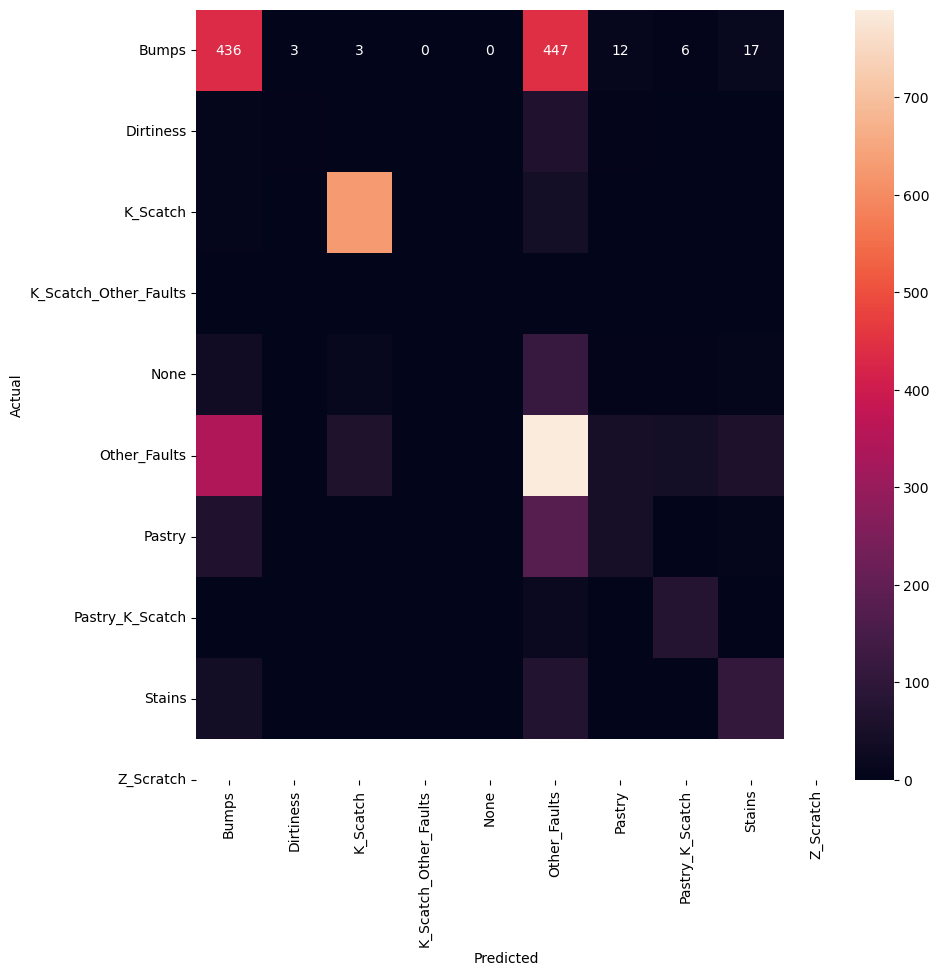

In [6]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=pipe.classes_, yticklabels=pipe.classes_)   
plt.ylabel('Actual')
plt.xlabel('Predicted')

-> The model performance sucks... MAybe trying to optimize with optuna

In [35]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    # parameters for optimizing the logistic regression
    C = trial.suggest_loguniform('C', 1e-10, 1e10)
    #penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    #solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga'])

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=10000, C=C, multi_class='multinomial', solver='lbfgs'))
        ])
    score = cross_val_score(pipe, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy').mean()

    return score

study = optuna.create_study(direction='maximize')



[I 2024-03-09 12:38:27,851] A new study created in memory with name: no-name-309712f0-e386-4356-8c24-033db63e5e86


In [37]:
# exclude the warning
import warnings
warnings.filterwarnings('ignore')
study.optimize(objective, n_trials=10)

[I 2024-03-09 12:38:56,135] Trial 1 finished with value: 0.5466666666666666 and parameters: {'C': 785555197.8098421}. Best is trial 1 with value: 0.5466666666666666.
[I 2024-03-09 12:39:09,280] Trial 2 finished with value: 0.5469268292682926 and parameters: {'C': 43147.59203135492}. Best is trial 2 with value: 0.5469268292682926.
[I 2024-03-09 12:39:10,232] Trial 3 finished with value: 0.5041300813008129 and parameters: {'C': 0.00019418378560515304}. Best is trial 2 with value: 0.5469268292682926.
[I 2024-03-09 12:39:14,227] Trial 4 finished with value: 0.33762601626016264 and parameters: {'C': 7.577315548706814e-10}. Best is trial 2 with value: 0.5469268292682926.
[I 2024-03-09 12:39:15,811] Trial 5 finished with value: 0.5480975609756097 and parameters: {'C': 0.029380686209750304}. Best is trial 5 with value: 0.5480975609756097.
[I 2024-03-09 12:39:32,814] Trial 6 finished with value: 0.5467967479674798 and parameters: {'C': 1136525195.1479125}. Best is trial 5 with value: 0.54809756

                precision    recall  f1-score   support

         Bumps       0.46      0.47      0.47       924
     Dirtiness       0.42      0.06      0.10        85
      K_Scatch       0.88      0.92      0.90       680
K_Scatch_Bumps       0.00      0.00      0.00         2
          None       0.00      0.00      0.00       183
  Other_Faults       0.46      0.59      0.51      1349
        Pastry       0.41      0.16      0.23       301
        Stains       0.59      0.76      0.66       100
     Z_Scratch       0.53      0.49      0.51       220

      accuracy                           0.54      3844
     macro avg       0.42      0.38      0.38      3844
  weighted avg       0.52      0.54      0.52      3844



<Axes: >

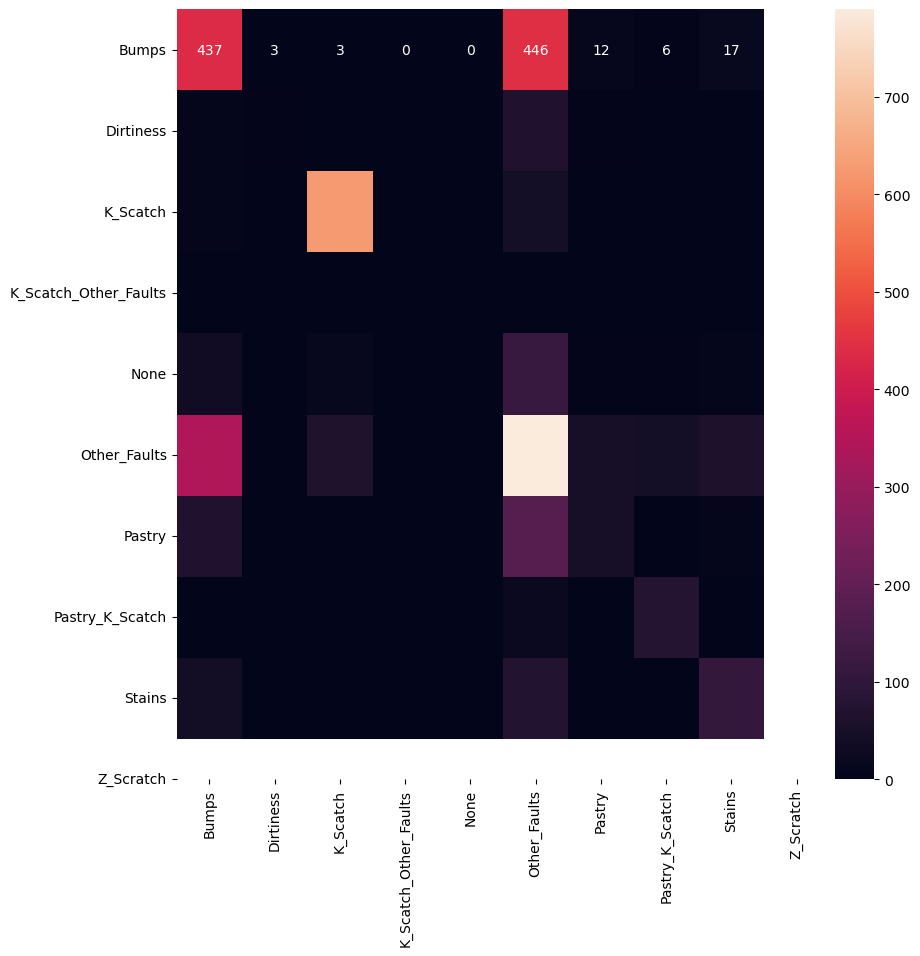

In [ ]:
# best model
best_params = study.best_params
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=10000, n_jobs=-1, C=best_params['C']))
])  
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=pipe.classes_, yticklabels=pipe.classes_)

optimizing this parameter -> also does not make thr model sufficient better